In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import datetime
import time
from tqdm import tqdm
from keras.datasets import fashion_mnist

In [14]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bullseye2608 (bullseye2608-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
def create_validation_set(X, Y, val_ratio=0.2, seed=None):
    """
    Splits X and Y into training and validation sets.

    Parameters:
    - X: Input data of shape (N, d).
    - Y: Corresponding labels of shape (N, ...).
    - val_ratio: Fraction of data to be used for validation (default is 0.2).
    - seed: Random seed for reproducibility.

    Returns:
    - X_train, X_val, Y_train, Y_val: The split datasets.
    """
    if seed is not None:
        np.random.seed(seed)
    
    n_samples = X.shape[0]
    # Generate a random permutation of indices
    indices = np.random.permutation(n_samples)
    # Determine split index based on the validation ratio
    split_index = int(n_samples * (1 - val_ratio))
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]
    
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_val = X[val_indices]
    Y_val = Y[val_indices]
    
    return X_train, X_val, Y_train, Y_val

In [66]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
(X_train, X_val, y_train, y_val) = create_validation_set(X_train, y_train, val_ratio=0.1, seed=42)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a DataFrame for the training data
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
train_df = pd.DataFrame(X_train_flat)
train_df['label'] = y_train
train_df['label_name'] = [class_names[label] for label in y_train]

# Create a DataFrame for the validation data
X_val_flat = X_val.reshape(X_val.shape[0], -1) / 255.0
val_df = pd.DataFrame(X_val_flat)
val_df['label'] = y_val
val_df['label_name'] = [class_names[label] for label in y_val]

# Create a DataFrame for the test data
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0
test_df = pd.DataFrame(X_test_flat)
test_df['label'] = y_test
test_df['label_name'] = [class_names[label] for label in y_test]

In [21]:
import wandb

# Initialize a W&B run
wandb.init(
    entity="bullseye2608-indian-institute-of-technology-madras",
    project="my-awesome-project", 
    name="Images_"+datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
)

# Log images to W&B
wandb.log({
    "fashion_mnist_samples": [
        wandb.Image(X_train[np.where(y_train == i)[0][0]], caption=class_names[i])
        for i in range(10)
    ]
})

wandb.finish()

In [67]:
def sigmoid(x):
    # For positive values, use standard formula
    # For negative values, use a mathematically equivalent but more stable form
    mask = x >= 0
    result = np.zeros_like(x, dtype=float)
    
    # For positive inputs: 1/(1+exp(-x))
    result[mask] = 1 / (1 + np.exp(-x[mask]))
    
    # For negative inputs: exp(x)/(1+exp(x))
    # This avoids computing exp of large positive numbers
    exp_x = np.exp(x[~mask])
    result[~mask] = exp_x / (1 + exp_x)
    
    return result

def softmax(X):
    # Subtract the max for numerical stability
    exps = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def cross_entropy_loss(y_true, y_pred, epsilon=1e-15):
    """
    Calculates the cross-entropy loss between true labels and predicted probabilities.
    
    Parameters:
    -----------
    y_true : numpy.ndarray
        One-hot encoded true labels or class indices.
        If class indices, shape should be (n_samples,)
        If one-hot encoded, shape should be (n_samples, n_classes)
    y_pred : numpy.ndarray
        Predicted probabilities, shape (n_samples, n_classes)
    epsilon : float, optional
        Small constant added to log to avoid numerical instability
        
    Returns:
    --------
    loss : float
        Average cross-entropy loss across all samples
    """
    # Convert y_true to one-hot if it's provided as class indices
    if len(y_true.shape) == 1 or y_true.shape[1] == 1:
        n_samples = len(y_true)
        n_classes = y_pred.shape[1]
        y_true_one_hot = np.zeros((n_samples, n_classes))
        y_true_one_hot[np.arange(n_samples), y_true.astype(int).flatten()] = 1
        y_true = y_true_one_hot
    
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Calculate cross entropy loss
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    
    return loss


def one_hot(y, transpose=False):
    one_hot_y = np.zeros((y.size, y.max() + 1))
    one_hot_y[np.arange(y.size), y] = 1
    if transpose:
        one_hot_y = one_hot_y.T
    return one_hot_y

def sigmoid_derivative(X):
    # Ensure X is in a safe range to avoid overflow
    X = np.clip(X, 1e-7, 1 - 1e-7)
    return X * (1 - X)

def plot_error(training_error, validation_error):
    plt.figure(figsize=(10, 6))
    plt.plot(training_error, label='Training Error')
    plt.plot(validation_error, label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Error')
    plt.title('Error vs. Epoch')
    plt.legend()
    plt.show()

In [10]:
def initialise_weights_and_biases(input_size=784, num_hidden_layers=2, num_neurons=32, output_size=10):
    """
    Initializes weights and biases for a neural network.

    Parameters:
    input_size (int): Size of the input layer.
    num_hidden_layers (int): Number of hidden layers.
    num_neurons (int or iterable): If an integer, the number of neurons in each hidden layer.
                                    If iterable, should contain the number of neurons for each hidden layer.
    output_size (int): Size of the output layer.

    Returns:
    tuple: (weights, biases) where weights is a list of numpy arrays representing the weight matrices 
            and biases is a list of numpy arrays representing the bias vectors.
    """
    weights, biases = [], []
    if type(num_neurons) == int:
        sizes = [input_size] + [num_neurons] * num_hidden_layers + [output_size]
    else:
        assert len(num_neurons) == num_hidden_layers
        sizes = [input_size] + list(num_neurons) + [output_size]
    for i in range(1, num_hidden_layers + 1):
        weights.append(np.random.uniform(-0.5, 0.5, (sizes[i], sizes[i - 1])))
        biases.append(np.zeros(sizes[i]).reshape(1, -1))
    weights.append(np.random.uniform(-0.5, 0.5, (sizes[-1], sizes[-2])))
    biases.append(np.zeros(sizes[-1]).reshape(1, -1))
    return weights, biases

def forward_propagation(X, W, B):
    """
    Performs forward propagation through the neural network.
    
    Parameters:
    X (numpy array): Input data.
    W (list): List of weight matrices.
    B (list): List of bias vectors.

    Returns:
    tuple: (A, H) where A is a list of linear combinations at each layer and H is a list of activations at each layer.
    """
    L = len(W)
    assert L==len(B) and L>=2
    A, H = [], []
    
    A_temp = np.dot(X, W[0].T) + B[0]
    H_temp = sigmoid(A_temp)
    
    A.append(A_temp)
    H.append(H_temp)
    
    for i in range(1,L-1):
        A_temp = np.dot(H[i-1], W[i].T) + B[i]
        H_temp = sigmoid(A_temp)
        
        A.append(A_temp)
        H.append(H_temp)
    
    A_temp = np.dot(H[L-2], W[L-1].T) + B[L-1]
    H_temp = softmax(A_temp)
    
    A.append(A_temp)
    H.append(H_temp)
    
    return A, H

def back_propagation_hardcoded(X, y_true, W, A, H):
    """
    Performs backpropagation to compute gradients for a three-layer neural network.

    Parameters:
    X (numpy array): Input data.
    y_true (numpy array): True labels.
    W (list): List of weight matrices.
    A (list): List of pre-activation values.
    H (list): List of activation values.

    Returns:
    tuple: (dW, dB) where dW is a list of gradients for the weight matrices and dB is a list of gradients for the bias vectors.
    """
    N = X.shape[0]
    L = len(W)
    assert N==y_true.size and L==len(A) and L==len(H)
    
    one_hot_y = one_hot(y_true)
    y_pred = H[2]
    dW, dB = [None] * L, [None] * L
    
    dA2 = y_pred - one_hot_y # NxK
    dW2 = (np.dot(dA2.T, H[1])) / N # KxH2
    dB2 = np.sum(dA2, axis=0).reshape(1,-1) / N # 1xK
    
    dA1 = np.dot(dA2, W[2]) * sigmoid_derivative(A[1]) # NxH2
    dW1 = (np.dot(dA1.T, H[0])) / N # H2xH1
    dB1 = np.sum(dA1, axis=0).reshape(1,-1) / N # 1xH2
    
    dA0 = np.dot(dA1, W[1]) * sigmoid_derivative(A[0]) # NxH1
    dW0 = (np.dot(dA0.T, X)) / N # H1xD
    dB0 = np.sum(dA0, axis=0).reshape(1,-1) / N # 1xH1
    
    dW = [dW0, dW1, dW2]
    dB = [dB0, dB1, dB2]
    
    return dW, dB
    
def back_propagation(X, y_true, W, A, H):
    """
    Performs backpropagation to compute gradients for the neural network using reverse layer iteration.

    Parameters:
    X (numpy array): Input data.
    y_true (numpy array): True labels.
    W (list): List of weight matrices.
    A (list): List of pre-activation values.
    H (list): List of activation values.

    Returns:
    tuple: (dW, dB) where dW is a list of gradients for the weight matrices and dB is a list of gradients for the bias vectors.
    """
    N = X.shape[0]
    L = len(W)
    assert N==y_true.size and L==len(A) and L==len(H)
    
    one_hot_y = one_hot(y_true)
    y_pred = H[L-1]
    dW, dB = [None] * L, [None] * L
    
    dA = y_pred - one_hot_y # NxK
    
    for k in range(L-1, 0, -1):
        dWk = (np.dot(dA.T, H[k-1])) / N
        dBk = np.sum(dA, axis=0).reshape(1,-1) / N
        
        dA = np.dot(dA, W[k]) * sigmoid_derivative(A[k-1])
        
        dW[k] = dWk
        dB[k] = dBk
    
    dW0 = (np.dot(dA.T, X)) / N
    dB0 = np.sum(dA, axis=0).reshape(1,-1) / N
    
    dW[0] = dW0
    dB[0] = dB0
    
    
    return dW, dB
 
def accuracy(y_true, y_pred):
    """
    Computes the accuracy of predictions.

    text
    Parameters:
    y_true (numpy array): True labels.
    y_pred (numpy array): Predicted labels.

    Returns:
    float: Accuracy value.
    """
    return np.mean(y_true == y_pred)

def test_model(X, y_true, W, B):
    """
    Tests the neural network model on the provided data and prints the accuracy.

    text
    Parameters:
    X (numpy array): Input data.
    y_true (numpy array): True labels.
    W (list): List of weight matrices.
    B (list): List of bias vectors.

    Returns:
    float: Accuracy of the model.
    """
    A, H = forward_propagation(X, W, B)
    y_pred = np.argmax(H[-1], axis=1)
    print(f'Accuracy: {accuracy(y_true, y_pred)}')
    return accuracy(y_true, y_pred)
    

In [68]:
   
def gradient_descent(X_training, y_true, X_val, y_val, W, B, learning_rate=0.01, num_iterations=1000, log_every=100):
    """
    Optimizes weights and biases using gradient descent over a specified number of iterations.

    Parameters:
    X_training (numpy array): Training input data.
    y_true (numpy array): Training true labels.
    X_val (numpy array): Validation input data.
    y_val (numpy array): Validation true labels.
    W (list): List of weight matrices.
    B (list): List of bias vectors.
    learning_rate (float): Learning rate for gradient descent.
    num_iterations (int): Total number of iterations.
    log_every (int): Frequency of logging loss.

    Returns:
    tuple: (W, B, training_error, validation_error) where W and B are updated parameters,
            and training_error and validation_error are arrays of loss values logged during training.
    """
    L = len(W)
    training_error = np.zeros(num_iterations//log_every)
    validation_error = np.zeros(num_iterations//log_every)
    for i in range(num_iterations):
        A, H = forward_propagation(X_training, W, B)
        dW, dB = back_propagation(X_training, y_true, W, A, H)
        
        for j in range(L):
            
            W[j] -= learning_rate * dW[j]
            B[j] -= learning_rate * dB[j]
        
        if i%log_every==0:
            training_error[i//log_every] = cross_entropy_loss(one_hot(y_true), H[-1])
            _, H_val = forward_propagation(X_val, W, B)
            validation_error[i//log_every] = cross_entropy_loss(one_hot(y_val), H_val[-1])
            print(f'Loss after {i} iterations: {training_error[i//log_every]}')
        
            
    
    return W, B, training_error, validation_error

def gradient_descent_with_momentum(X_training, y_true, X_val, y_val, W, B, learning_rate=0.01, momentum=0.4, num_iterations=100, log_every=100):
    """
    Optimizes weights and biases using gradient descent with momentum.

    Parameters:
    X (numpy array): Input data.
    y_true (numpy array): True labels for training data.
    W (list): List of weight matrices.
    B (list): List of bias vectors.
    learning_rate (float): Learning rate for updates.
    momentum (float): Momentum coefficient.
    num_iterations (int): Total number of iterations.
    log_every (int): Frequency of logging training and validation loss.

    Returns:
    tuple: (W, B, training_error, validation_error) where W and B are updated parameters,
            and training_error and validation_error are arrays of loss values logged during training.
    """
    L = len(W)
    training_error = np.zeros(num_iterations//log_every)
    validation_error = np.zeros(num_iterations//log_every)
    
    velocity_W = [np.zeros_like(W[j]) for j in range(L)]
    velocity_B = [np.zeros_like(B[j]) for j in range(L)]
    
    for i in range(num_iterations):
        
        A, H = forward_propagation(X_training, W, B)
        dW, dB = back_propagation(X_training, y_true, W, A, H)
        
        for j in range(L):
            velocity_W[j] = momentum * velocity_W[j] - learning_rate * dW[j]
            velocity_B[j] = momentum * velocity_B[j] - learning_rate * dB[j]
            
            W[j] += velocity_W[j]
            B[j] += velocity_B[j]
        
        if i % log_every == 0:
            training_error[i//log_every] = cross_entropy_loss(one_hot(y_true), H[-1])
            _, H_val = forward_propagation(X_val, W, B)
            validation_error[i//log_every] = cross_entropy_loss(one_hot(y_val), H_val[-1])
            print(f'Loss after {i} iterations: {training_error[i//log_every]}')
            
    return W, B, training_error, validation_error

def nesterov_accelerated_gradient(X_training, y_true, X_val, y_val, W, B, learning_rate=0.01, momentum=0.9, num_iterations=100, log_every=100):
    L = len(W)
    
    velocity_W = [np.zeros_like(W[j]) for j in range(L)]
    velocity_B = [np.zeros_like(B[j]) for j in range(L)]
    
    training_error = np.zeros(num_iterations//log_every)
    validation_error = np.zeros(num_iterations//log_every)
    
    for i in range(num_iterations):
        W_lookahead = [None] * len(W)
        B_lookahead = [None] * len(B)
        
        for j in range(L):
            W_lookahead[j] = W[j] + momentum * velocity_W[j]
            B_lookahead[j] = B[j] + momentum * velocity_B[j]
        
        A, H = forward_propagation(X_training, W_lookahead, B_lookahead)
        dW, dB = back_propagation(X_training, y_true, W_lookahead, A, H)
        
        for j in range(L):
            velocity_W[j] = momentum * velocity_W[j] - learning_rate * dW[j]
            velocity_B[j] = momentum * velocity_B[j] - learning_rate * dB[j]
            
            W[j] += velocity_W[j]
            B[j] += velocity_B[j]
        
        if i % log_every == 0:
            training_error[i//log_every] = cross_entropy_loss(one_hot(y_true), H[-1])
            _, H_val = forward_propagation(X_val, W, B)
            validation_error[i//log_every] = cross_entropy_loss(one_hot(y_val), H_val[-1])
            print(f'Loss after {i} iterations: {training_error[i//log_every]}')
    
    return W, B, training_error, validation_error

def rmsprop(X_training, y_true, X_val, y_val, W, B, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8, num_iterations=100, log_every=100):
    L = len(W)
    
    cache_W = [np.zeros_like(W[j]) for j in range(L)]
    cache_B = [np.zeros_like(B[j]) for j in range(L)]
    
    training_error = np.zeros(num_iterations//log_every)
    validation_error = np.zeros(num_iterations//log_every)
    
    for i in range(num_iterations):
        A, H = forward_propagation(X_training, W, B)
        dW, dB = back_propagation(X_training, y_true, W, A, H)
        
        for j in range(L):
            cache_W[j] = decay_rate * cache_W[j] + (1 - decay_rate) * np.square(dW[j])
            cache_B[j] = decay_rate * cache_B[j] + (1 - decay_rate) * np.square(dB[j])
            
            W[j] -= learning_rate * dW[j] / (np.sqrt(cache_W[j]) + epsilon)
            B[j] -= learning_rate * dB[j] / (np.sqrt(cache_B[j]) + epsilon)
        
        if i % log_every == 0:
            training_error[i//log_every] = cross_entropy_loss(one_hot(y_true), H[-1])
            _, H_val = forward_propagation(X_val, W, B)
            validation_error[i//log_every] = cross_entropy_loss(one_hot(y_val), H_val[-1])
            print(f'Loss after {i} iterations: {training_error[i//log_every]}')
    
    return W, B, training_error, validation_error

def adam(X_training, y_true, X_val, y_val, W, B, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, num_iterations=100, log_every=100):
    L = len(W)
    
    m_W = [np.zeros_like(W[j]) for j in range(L)]  
    m_B = [np.zeros_like(B[j]) for j in range(L)]
    
    v_W = [np.zeros_like(W[j]) for j in range(L)]  
    v_B = [np.zeros_like(B[j]) for j in range(L)]
    
    training_error = np.zeros(num_iterations//log_every)
    validation_error = np.zeros(num_iterations//log_every)
    
    for i in range(num_iterations):
        t = i + 1  
        
        A, H = forward_propagation(X_training, W, B)
        dW, dB = back_propagation(X_training, y_true, W, A, H)
        
        for j in range(L):
            m_W[j] = beta1 * m_W[j] + (1 - beta1) * dW[j]
            v_W[j] = beta2 * v_W[j] + (1 - beta2) * np.square(dW[j])
            
            m_W_corrected = m_W[j] / (1 - beta1**t)
            v_W_corrected = v_W[j] / (1 - beta2**t)
            
            W[j] -= learning_rate * m_W_corrected / (np.sqrt(v_W_corrected) + epsilon)
            
            m_B[j] = beta1 * m_B[j] + (1 - beta1) * dB[j]
            v_B[j] = beta2 * v_B[j] + (1 - beta2) * np.square(dB[j])
            
            m_B_corrected = m_B[j] / (1 - beta1**t)
            v_B_corrected = v_B[j] / (1 - beta2**t)
            
            B[j] -= learning_rate * m_B_corrected / (np.sqrt(v_B_corrected) + epsilon)
        
        if i % log_every == 0:
            training_error[i//log_every] = cross_entropy_loss(one_hot(y_true), H[-1])
            _, H_val = forward_propagation(X_val, W, B)
            validation_error[i//log_every] = cross_entropy_loss(one_hot(y_val), H_val[-1])
            print(f'Loss after {i} iterations: {training_error[i//log_every]}')
    
    return W, B, training_error, validation_error

def nadam(X_training, y_true, X_val, y_val, W, B, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, num_iterations=100, log_every=100):
    L = len(W)
    
    m_W = [np.zeros_like(W[j]) for j in range(L)] 
    m_B = [np.zeros_like(B[j]) for j in range(L)]
    
    v_W = [np.zeros_like(W[j]) for j in range(L)] 
    v_B = [np.zeros_like(B[j]) for j in range(L)]
    
    training_error = np.zeros(num_iterations//log_every)
    validation_error = np.zeros(num_iterations//log_every)
    
    for i in range(num_iterations):
        t = i + 1  
        
        A, H = forward_propagation(X_training, W, B)
        dW, dB = back_propagation(X_training, y_true, W, A, H)
        
        for j in range(L):
            m_W[j] = beta1 * m_W[j] + (1 - beta1) * dW[j]
            v_W[j] = beta2 * v_W[j] + (1 - beta2) * np.square(dW[j])
            
            m_W_corrected = m_W[j] / (1 - beta1**t)
            v_W_corrected = v_W[j] / (1 - beta2**t)
            
            m_W_nesterov = beta1 * m_W_corrected + (1 - beta1) * dW[j] / (1 - beta1**t)
            
            W[j] -= learning_rate * m_W_nesterov / (np.sqrt(v_W_corrected) + epsilon)
            
            m_B[j] = beta1 * m_B[j] + (1 - beta1) * dB[j]
            v_B[j] = beta2 * v_B[j] + (1 - beta2) * np.square(dB[j])
            
            m_B_corrected = m_B[j] / (1 - beta1**t)
            v_B_corrected = v_B[j] / (1 - beta2**t)
            
            m_B_nesterov = beta1 * m_B_corrected + (1 - beta1) * dB[j] / (1 - beta1**t)
            
            B[j] -= learning_rate * m_B_nesterov / (np.sqrt(v_B_corrected) + epsilon)
        
        if i % log_every == 0:
            training_error[i//log_every] = cross_entropy_loss(one_hot(y_true), H[-1])
            _, H_val = forward_propagation(X_val, W, B)
            validation_error[i//log_every] = cross_entropy_loss(one_hot(y_val), H_val[-1])
            print(f'{i} iterations')
            print(f'Training Loss: {training_error[i//log_every]}')
            print(f'Validation Loss: {validation_error[i//log_every]}')
    
    return W, B, training_error, validation_error

In [69]:
# Testing Forward Propagation and Back Propagation

num_trials = 19

W, B = initialise_weights_and_biases(input_size=784, 
                            num_hidden_layers=1, 
                            num_neurons=41, 
                            output_size=10)


A, H = forward_propagation(X=X_train_flat[:num_trials,:], W=W, B=B)

dW, dB = back_propagation(X=X_train_flat[:num_trials,:], y_true=y_train[:num_trials], W=W, A=A, H=H)

In [41]:
num_trials = 2000

W, B = initialise_weights_and_biases(input_size=784, 
                            num_hidden_layers=2, 
                            num_neurons=32, 
                            output_size=10)

W_new, B_new, training_error, validation_error = gradient_descent(X_training=X_train_flat[:num_trials,:],
                                                                y_true=y_train[:num_trials],
                                                                X_val=X_val_flat,
                                                                y_val=y_val,
                                                                W=W, B=B,
                                                                learning_rate=0.1,
                                                                num_iterations=5000,
                                                                log_every=100)


Loss after 0 iterations: 2.6043603318994553
Loss after 100 iterations: 2.1607028811476057
Loss after 200 iterations: 2.0002504646008483
Loss after 300 iterations: 1.8525557771278918


KeyboardInterrupt: 

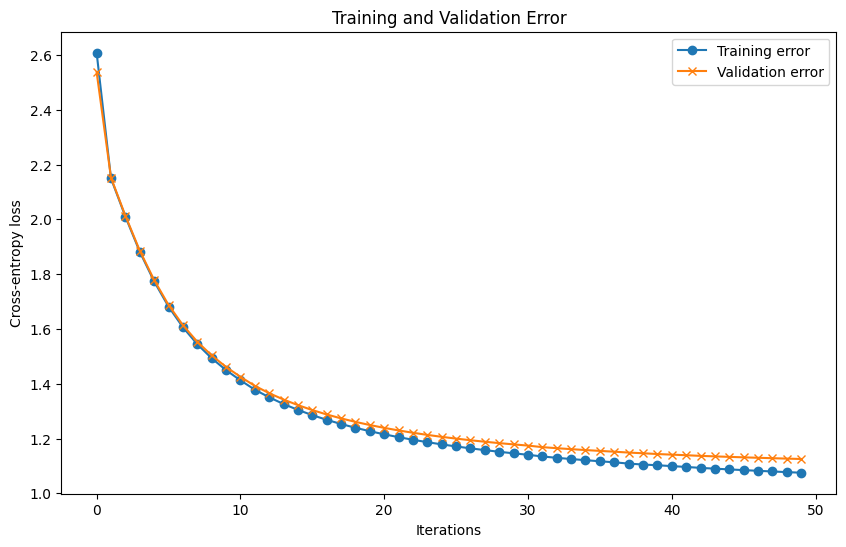

In [26]:
plt.figure(figsize=(10, 6))
plt.title('Training and Validation Error')
plt.plot(training_error, label='Training error', marker='o')
plt.plot(validation_error, label='Validation error', marker='x')
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

In [70]:
num_trials = 2000

W, B = initialise_weights_and_biases(input_size=784, 
                            num_hidden_layers=1, 
                            num_neurons=32, 
                            output_size=10)

test_model(X=X_test_flat, y_true=y_test, W=W, B=B)

Accuracy: 0.1095


0.1095

In [74]:
W_new, B_new, training_error, validation_error = nesterov_accelerated_gradient(X_training=X_train_flat,
                                                                            y_true=y_train,
                                                                            X_val=X_val_flat, y_val=y_val,
                                                                            W=W, B=B,
                                                                            learning_rate=0.05,
                                                                            momentum=0.9,
                                                                            num_iterations=4000,
                                                                            log_every=100)

Loss after 0 iterations: 0.42066934047524207
Loss after 100 iterations: 0.41927561513051903
Loss after 200 iterations: 0.4177960027501044
Loss after 300 iterations: 0.416347959563622
Loss after 400 iterations: 0.41491774355763517
Loss after 500 iterations: 0.4135140758968602
Loss after 600 iterations: 0.4121553134010769
Loss after 700 iterations: 0.41082791734714336
Loss after 800 iterations: 0.4095261177234566
Loss after 900 iterations: 0.4082584694471631
Loss after 1000 iterations: 0.4070222388327439
Loss after 1100 iterations: 0.4058192889060566
Loss after 1200 iterations: 0.4046463529424896
Loss after 1300 iterations: 0.403498769743881
Loss after 1400 iterations: 0.40237709460537746
Loss after 1500 iterations: 0.4012843105986053
Loss after 1600 iterations: 0.40021518213524687
Loss after 1700 iterations: 0.39916851936392594
Loss after 1800 iterations: 0.39814295273639827
Loss after 1900 iterations: 0.39714053081132383
Loss after 2000 iterations: 0.3961583956844574
Loss after 2100 it

In [72]:
test_model(X=X_val_flat, y_true=y_val, W=W_new, B=B_new)

Accuracy: 0.8396666666666667


0.8396666666666667

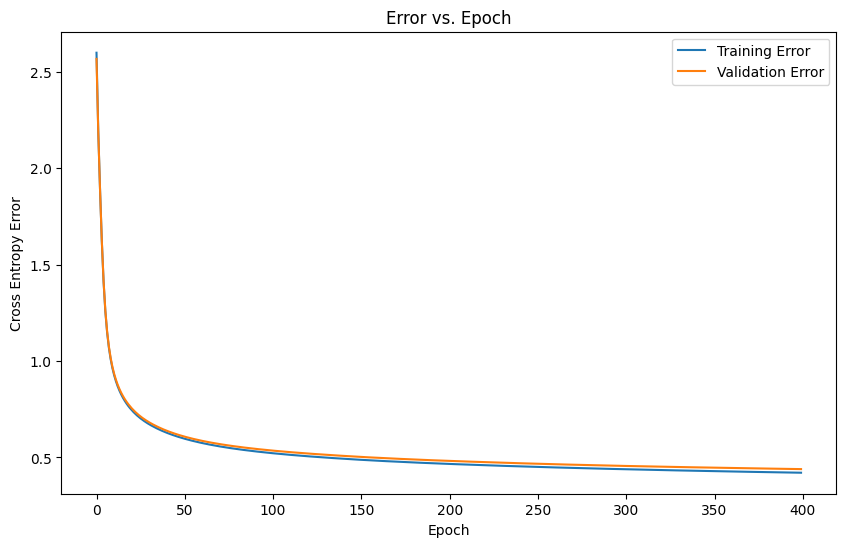

In [73]:
plot_error(training_error, validation_error)